<a href="https://colab.research.google.com/github/trogdentyler/cs611/blob/main/hmwk/hw12_prob5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch
!pip3 intall tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "intall" - maybe you meant "install"


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

In [3]:
# create mnist dataset object

class MNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    # download mnist data from torchvision
    
    self.data = datasets.MNIST(root, train=train, transform=transforms.ToTensor(), download=True)

  def __getitem__(self, i):
    x, y = self.data[i]

    return x, y

  def __len__(self):
    return len(self.data)

In [4]:
# create CNN architecture

class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN, self).__init__()
    
    # number of classes we're fitting to
    out_dim = 10

    self.conv1 = nn.Sequential(         
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
    
    self.conv2 = nn.Sequential(         
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
    
    self.conv3 = nn.Sequential(         
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
    
    # fully connected layer, output 10 classes
    self.out = nn.Linear(in_features=576, out_features=out_dim)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)

    # flatten the output of conv3 to (batch_size, 64 * 7 * 7)
    x = x.view(x.size(0), -1)       
    output = self.out(x)

    # return x for visualization
    return output

In [5]:
# define train and val datasets
train_data = MNISTProcessedDataset('/tmp/mnist')
val_data = MNISTProcessedDataset('/tmp/mnist', train=False)

# define dataloaders which will shuffle our data and hand us a batch when prompted
batch_size = 42
train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# instantiate model
model = CustomCNN()
model.cuda() # use the GPU for calculation with the model

# instantiate optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# instantiate loss
objective = nn.CrossEntropyLoss()

100%|██████████| 9912422/9912422 [00:00<00:00, 291473017.70it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40432474.57it/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 147520133.88it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 15513459.91it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



epoch:4 batch:1428 loss:0.0166 val_loss:0.0543: 100%|██████████| 7145/7145 [08:56<00:00, 13.32it/s]


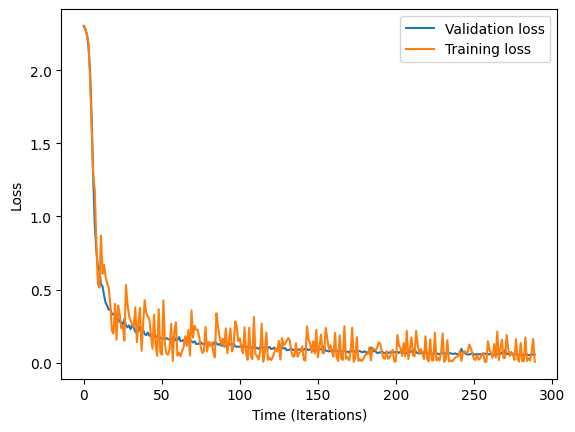

In [6]:
# Run your training/validation loops
train_losses = []
validation_losses = []

# play with number of epochs if training loss is too high
num_epochs = 5

# loop status bar
loop = tqdm(total=len(train_loader) * num_epochs, position=0)

for epoch in range(num_epochs):
  # train
  batch = 0

  for x, y_truth in train_loader:
    # send tensors to GPU
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

    optimizer.zero_grad()

    # evaluate model on input and get loss
    y_hat = model(x)
    loss = objective(y_hat, y_truth)

    # here we'll run through our validation/test data
    if batch % 25 == 0:
      train_losses.append(loss.item())
      validation_loss_list = []

      for val_x, val_y_truth in val_loader:
        val_x, val_y_truth = val_x.cuda(non_blocking=True), val_y_truth.cuda(non_blocking=True)

        val_y_hat = model(val_x)
        validation_loss_list.append(objective(val_y_hat, val_y_truth))

      validation_losses.append( (sum(validation_loss_list) / len(validation_loss_list) ).item() )

    loop.set_description('epoch:{} batch:{} loss:{:.4f} val_loss:{:.4f}'.format(epoch, batch, loss.item(), validation_losses[-1]))
    loop.update()

    loss.backward()
    optimizer.step()

    batch += 1

loop.close()

# create a plot of your loss over time
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(len(validation_losses)), validation_losses, label="Validation loss")
ax.plot(range(len(train_losses)), train_losses, label="Training loss")

plt.xlabel("Time (Iterations)")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
# test prediction against actual labels
imgs, lbls = next(iter(val_loader))
imgs = imgs.cuda()

test_output = model(imgs)
pred_lbls = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()

actual_lbls = lbls.numpy()

print(f'Prediction number: {pred_lbls}')
print(f'Actual number: {actual_lbls}')
print('\n', pred_lbls == actual_lbls)

Prediction number: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7]
Actual number: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7]

 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
